In [65]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [66]:
num_workers = 0
batch_size = 20
validation_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.MNIST(root = 'data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root = 'data', train=False, download=True, transform=transform)

# Preparing Validation Indices
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining indices for validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler = train_sampler, 
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler = valid_sampler, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Visualize the data

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

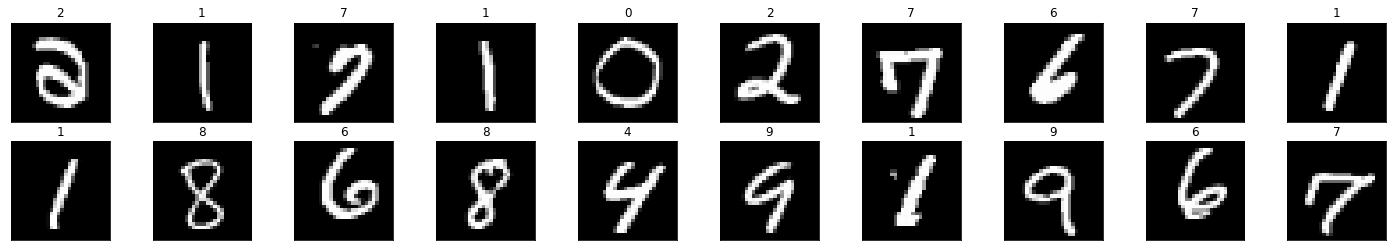

In [69]:
fig = plt.figure(figsize=(25,4))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title( str(labels[idx].item()) )

## View an Image in detail

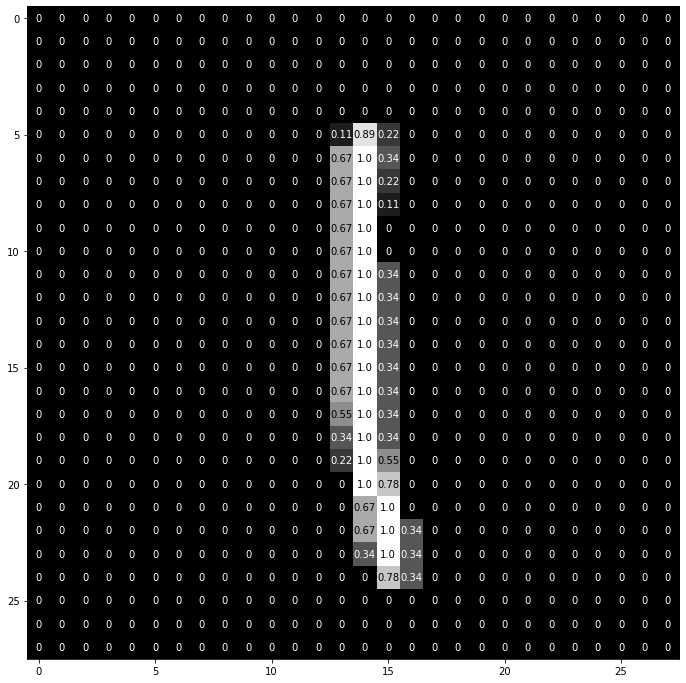

In [70]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
# More info: https://stackoverflow.com/questions/49078309/why-does-it-pass-y-x-instead-of-x-y-to-ax-annotate
# The annotation function is working correctly and the documentation is also correct, 
# xy = (x,y) means x is the horizontal component, and y is the vertical one. 
# This is consistent with usual nomenclature of plotting and graphs worldwide.

# Define Neural Network

In [71]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [72]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the network

In [73]:
# number of epochs to train the model
n_epochs = 40

# initialize tracker for minimum validation loss
valid_loss_min = np.inf

# Train
for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train() #Put model in training mode
    for data, label in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0) # loss gives average loss over the mini-batch, hence the multiplication
    
    #Valid model
    model.eval() # Put model out of training mode
    for data, label in valid_loader:
        output = model(data)
        loss = criterion(output, label)
        valid_loss += loss.item() * data.size(0) # loss gives average loss over the mini-batch, hence the multiplication
    
    # Get average loss over the epoch
    train_loss = train_loss / len(train_loader.sampler) # len(sampler) provides the number of items in the dataset 
    valid_loss = valid_loss / len(valid_loader.sampler) # len(sampler) provides the number of items in the dataset

    print ("Epoch {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}".format(
        epoch+1, train_loss, valid_loss))
    
    # Save Model
    if (valid_loss < valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        # Can even add early stopping if loss does not improve after certain epochs!!

Epoch 1 	 Training Loss: 0.935296 	 Validation Loss: 0.389308
Validation loss decreased (inf --> 0.389308).  Saving model ...
Epoch 2 	 Training Loss: 0.351229 	 Validation Loss: 0.293326
Validation loss decreased (0.389308 --> 0.293326).  Saving model ...
Epoch 3 	 Training Loss: 0.277101 	 Validation Loss: 0.238505
Validation loss decreased (0.293326 --> 0.238505).  Saving model ...
Epoch 4 	 Training Loss: 0.227986 	 Validation Loss: 0.202448
Validation loss decreased (0.238505 --> 0.202448).  Saving model ...
Epoch 5 	 Training Loss: 0.190090 	 Validation Loss: 0.175003
Validation loss decreased (0.202448 --> 0.175003).  Saving model ...
Epoch 6 	 Training Loss: 0.166264 	 Validation Loss: 0.159902
Validation loss decreased (0.175003 --> 0.159902).  Saving model ...
Epoch 7 	 Training Loss: 0.146446 	 Validation Loss: 0.140706
Validation loss decreased (0.159902 --> 0.140706).  Saving model ...
Epoch 8 	 Training Loss: 0.132032 	 Validation Loss: 0.128874
Validation loss decreased 

# Load Model with lowest validation loss

In [74]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

# Test the Model

In [75]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, label in test_loader:
    output = model(data)
    loss = criterion(output, label)
    test_loss += loss.item() * data.size(0)
    _, pred_idx = torch.max(output,1)
    correct = np.squeeze(pred_idx.eq(label.data.view_as(pred_idx)))
    for i in range(10):
        target = label.data[i]
        class_correct[target] += correct[i].item()
        class_total[target] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.059654

Test Accuracy of     0: 98% (477/482)
Test Accuracy of     1: 99% (549/554)
Test Accuracy of     2: 97% (502/513)
Test Accuracy of     3: 98% (510/518)
Test Accuracy of     4: 97% (477/490)
Test Accuracy of     5: 98% (406/412)
Test Accuracy of     6: 98% (478/484)
Test Accuracy of     7: 97% (517/529)
Test Accuracy of     8: 96% (477/493)
Test Accuracy of     9: 97% (510/525)

Test Accuracy (Overall): 98% (4903/5000)


# Visualize Test Results

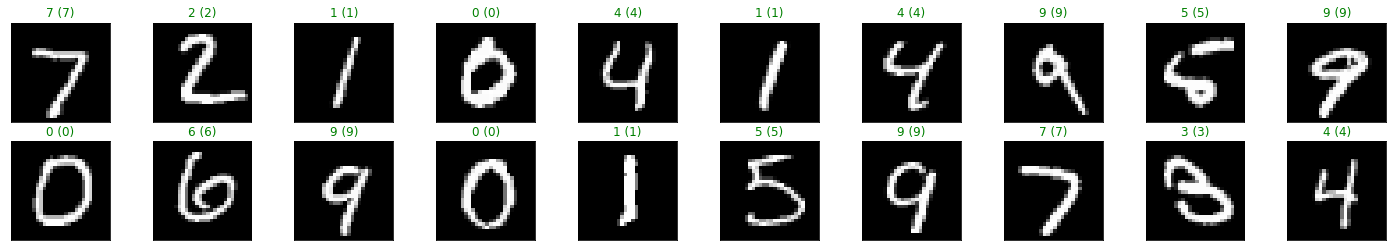

In [76]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))